<a href="https://colab.research.google.com/github/razzlestorm/DS-Unit-2-Applied-Modeling/blob/master/Jerimiah_Willhite_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import pandas_profiling
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [0]:


train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [4]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [157]:
print(train[train['City'] == "CHICAGO"].shape)
print(train[train['State'] == "IL"].shape)

#I looked at the city and state where they weren't chicago and IL, and they were NaNs, so these would cause a high ROC AUC score,
#because they are all at the same place, and highly correlated
#LET'S DROP IT LIKE IT'S HOT TO REDUCE DATA LEAKAGE


(51659, 17)
(51906, 17)


In [35]:
#consider stripping violations later and seeing if I can get something with only the numeric codes, but drop this for now
#sum(train['Violations'].isna())

9655

In [158]:
train.profile_report(style={'full_width':True})

In [0]:
def wrangle(X):
    X = X.copy()
    
    #Drop ID/license, duplicate columns, and columns with only identical values in rows
    X = X.drop(columns=['Inspection ID', 'Violations', 'DBA Name', 'License #', 'Location', 'City', 'State'])
    
    # Convert date_recorded to datetime
    #X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
    
    return X

train = wrangle(train)
test = wrangle(test)

In [6]:
#splitting 
target = train['Fail']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    train, target, train_size =0.8, test_size=0.2, stratify=target, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, train_size =0.8, test_size=0.2, 
    stratify=y_trainval, random_state=42)


print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (33225, 10)
y_train shape (33225,)
X_val shape (8307, 10)
y_val shape (8307,)
X_test shape (10384, 10)
y_test shape (10384,)


In [7]:
y_train.value_counts(normalize=True)
#baseline is that 74% passed

0    0.741369
1    0.258631
Name: Fail, dtype: float64

In [8]:
y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)
#checking to make sure this is all okay so far

0.5

In [9]:
null_counts = X_train.isnull().sum().sort_values(ascending=False)
null_counts.reset_index()

,index,0
0,AKA Name,402
1,Facility Type,138
2,Longitude,124
3,Latitude,124
4,Zip,16
5,Risk,9
6,Inspection Type,1
7,Fail,0
8,Inspection Date,0
9,Address,0


In [0]:
#wrangle data again

def fixed(X):
    
    X = X.copy()
    #mapping risk
    #risk_rank = {'Risk 3 (Low)': 1, 'Risk 2 (Medium)': 2, 'Risk 1 (High)': 3}
    #X['Risk'] = X['Risk'].map(risk_rank, na_action='ignore')
    


    
    #Handling NaNs
    X['Inspection Type'] = X['Inspection Type'].dropna()
    X['Facility Type'] = X['Facility Type'].dropna()
    X['Latitude'] = X['Latitude'].dropna()
    X['Longitude'] = X['Longitude'].dropna()
    X['Zip'] = X['Zip'].dropna()
    X['Fail'] = X['Fail'].dropna()
    
    #dropping inspection date -thought this might have something to do with overfitting but I guess not?
    X = X.drop(columns='Inspection Date')
    
    #dropping fail
    X = X.drop(columns='Fail')
    
    #dropping AKA Name (probably minimal effects)
    X = X.drop(columns='AKA Name')
    
    #Dropping 
    
    return X
    
X_train = fixed(X_train)
X_val   = fixed(X_val)
X_test  = fixed(X_test)

In [11]:
X_train.head()

,Facility Type,Risk,Address,Zip,Inspection Type,Latitude,Longitude
38692,Restaurant,Risk 1 (High),3411 N HALSTED ST,60657.0,Canvass,41.943980,-87.649239
51464,Restaurant,Risk 1 (High),58 E OAK ST,60611.0,License,41.900892,-87.626223
33701,Restaurant,Risk 1 (High),5961 N LINCOLN AVE,60659.0,Canvass,41.989506,-87.705658
26538,School,Risk 1 (High),2211 W 18th PL,60608.0,Canvass Re-Inspection,41.856584,-87.681503
8619,Grocery Store,Risk 2 (Medium),1158 W MARQUETTE RD,60621.0,Canvass,41.772444,-87.654252


## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
rf = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

rf.fit(X_train, y_train);

In [14]:
rf_y_pred = rf.predict(X_val)
roc_auc_score(y_val, rf_y_pred)

0.5776010443906859

In [15]:
rf_y_pred_proba = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, rf_y_pred_proba)

0.6544276849702619

In [0]:
xgb = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=1000, n_jobs=-1)
)

xgb.fit(X_train, y_train);

In [17]:
xgb_y_pred = xgb.predict(X_val)
roc_auc_score(y_val, xgb_y_pred)

0.5435832877534897

In [18]:
xgb_y_pred_proba = xgb.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, xgb_y_pred_proba)

0.6916036787998245

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

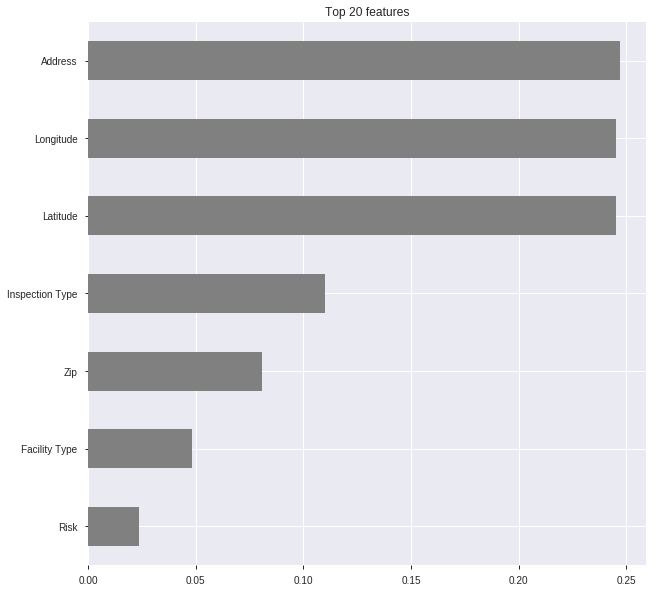

In [19]:
# Get feature importances
rfsteps = rf.named_steps['randomforestclassifier']
importances = pd.Series(rfsteps.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey'); 

In [20]:
#permutation importances
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy="median")
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
#permutation importances
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Using TensorFlow backend.


Weight,Feature
0.0267 ± 0.0014,Inspection Type
0.0061 ± 0.0024,Latitude
0.0017 ± 0.0001,Longitude
0.0004 ± 0.0010,Zip
-0.0006 ± 0.0024,Facility Type
-0.0036 ± 0.0017,Risk
-0.0048 ± 0.0026,Address


In [22]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_permuted = X_train[features]

X_train_permuted.shape

(33225, 4)

In [23]:
X_val_permuted = X_val[features]
X_val_permuted.shape
#same number of columns

(8307, 4)

In [25]:
perm_xgb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

perm_xgb.fit(X_train_permuted, y_train)
print('Validation Accuracy', perm_xgb.score(X_val_permuted, y_val))

#Look mom, I improved my score!

Validation Accuracy 0.7438305043938847


In [26]:
#Shapley Values what whaaaaaaaaaat
import shap

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)




[0]	validation_0-auc:0.664532	validation_1-auc:0.6728
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.666436	validation_1-auc:0.675387
[2]	validation_0-auc:0.66634	validation_1-auc:0.67487
[3]	validation_0-auc:0.666436	validation_1-auc:0.675387
[4]	validation_0-auc:0.671485	validation_1-auc:0.677822
[5]	validation_0-auc:0.671591	validation_1-auc:0.678369
[6]	validation_0-auc:0.671885	validation_1-auc:0.678532
[7]	validation_0-auc:0.671805	validation_1-auc:0.678245
[8]	validation_0-auc:0.671895	validation_1-auc:0.678562
[9]	validation_0-auc:0.672033	validation_1-auc:0.678516
[10]	validation_0-auc:0.672869	validation_1-auc:0.679297
[11]	validation_0-auc:0.672988	validation_1-auc:0.679316
[12]	validation_0-auc:0.673006	validation_1-auc:0.679301
[13]	validation_0-auc:0.676463	validation_1-auc:0.681984
[14]	validation_0-auc:0.680139	validation_1-auc:0.685464
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [27]:
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6880285306345862


In [28]:
#grocery store
row = X_test.iloc[[8619]]
explainer = shap.TreeExplainer(model)
row_process = processor.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

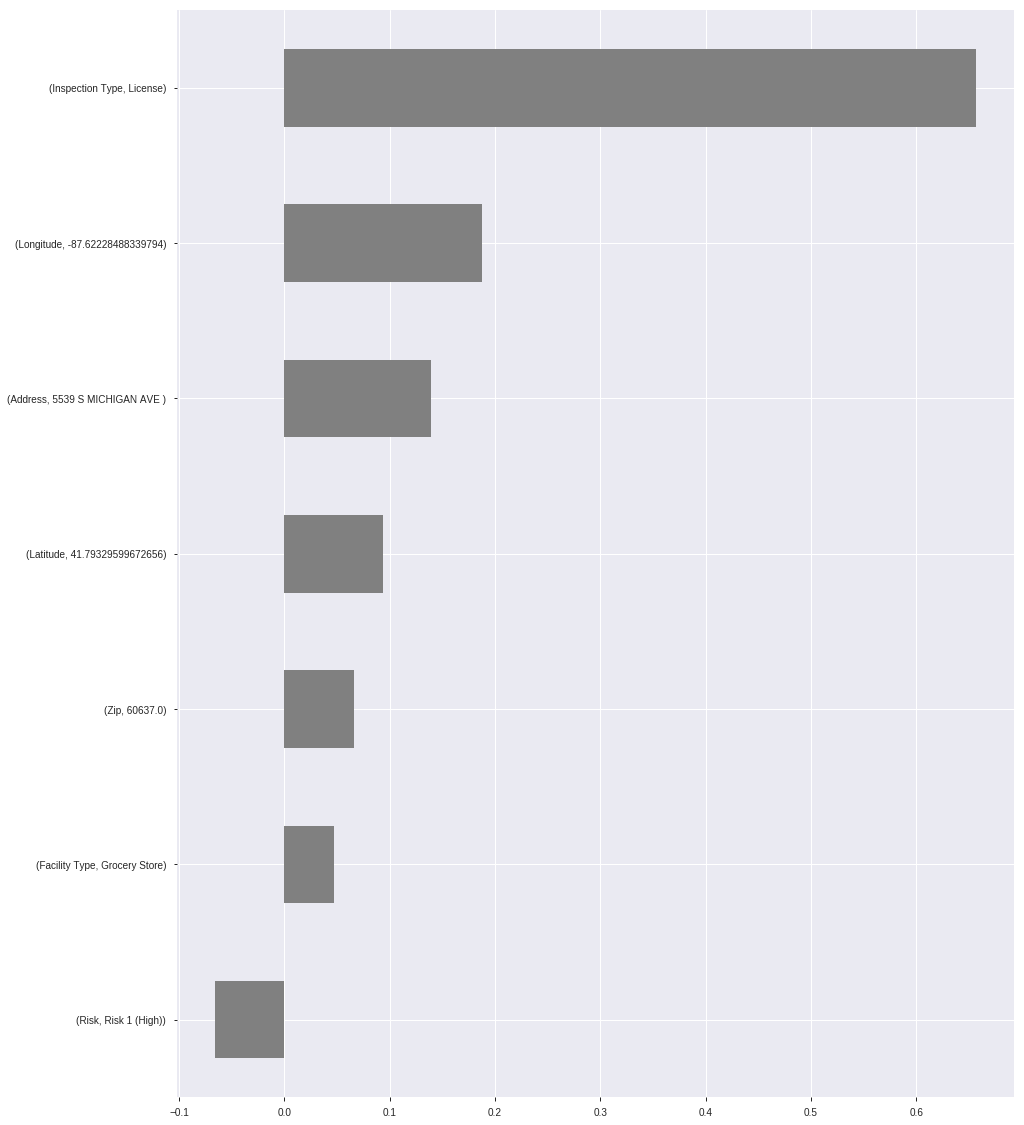

In [29]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names,feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));

#I don't know how high risk has a negative effect, but OKAY SURE